[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_CAMS.png)](https://atmosphere.copernicus.eu)

# CAMS-MOS

 **Run the tutorial via free cloud platforms**: [![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/cams-act6/main?labpath=05-cams-mos/cams-mos.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/cams-act6/blob/main/05-cams-mos/cams-mos.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/cams-act6/blob/main/05-cams-mos/cams-mos.ipynb)

## Learning objectives

In this notebook we download and plot air-quality point forecasts from the CAMS Atmosphere Data Store. We use the [CAMS European air quality forecasts optimised at observation sites](https://ads-beta.atmosphere.copernicus.eu/datasets/cams-europe-air-quality-forecasts-optimised-at-observation-sites?tab=overview) dataset. We select one european country, from which we get the raw data and the MOS-optimised data, in CSV format, for four pollutants, $NO_2$, $O_3$, $PM10$, and $PM2.5$, from all the stations located there. For "raw" data we mean the forecasts from the gridded CAMS ensemble model interpolated over each station. A detailed description is available at the ECMWF documentation website: [CAMS Regional: European Air Quality Forecast Optimised at Observation Sites data documentation](https://confluence.ecmwf.int/display/CKB/CAMS+Regional%3A+European+Air+Quality+Forecast+Optimised+at+Observation+Sites+data+documentation). Examples of air quality data used for policy support and decision making are available at the [Policy Support](https://policy.atmosphere.copernicus.eu/) of the CAMS web site.

## Initial setup

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the Climate Data Store (CDS), intalling any other packages not already installed, setting up our CDS API credentials and importing the various Python libraries that we will need.

In [1]:
# Ensure that the cdsapi package is installed
!pip install -q cdsapi

In [2]:
# If you are running this notebook in Colab, uncomment the line below and run this cell.
#!pip install cartopy

### Add your ADS API credentials

To set up your ADS API credentials, please login/register on the [ADS](https://ads.atmosphere.copernicus.eu/), then you will see your [unique API key here](https://ads.atmosphere.copernicus.eu/api-how-to). 

You can add this API key to your current session by replacing `#########` in the code cell below with your API key.

In [1]:
import os
os.environ['CDSAPI_URL'] = 'https://ads-beta.atmosphere.copernicus.eu/api'
os.environ['CDSAPI_KEY'] = '###########################################'

### Import libraries

In [4]:
import os
import sys
import yaml
import json
import cdsapi
import zipfile
import hashlib
import pandas as pd
import math
import datetime
from math import ceil, sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

## Data access and preprocessing
We want the raw data for four pollutants from the CAMS ensemble model and the MOS-optimised data for all the stations in the european selected country. The data is provided as CVS files. With the data an additional file with a list of the stations is also provided. All the files are zipped for download. The forecasts (lead time hours) are available for 24, 48, 72, and 96 hours starting from each of the the days that have been requested. The days of the forecasts can be in the past till the current day. So if we want the forecast from today for the next 24 hours, in the request we set the current year, month and day, e.g. 2024, 08, 28, and 0-23 for the lead time hours. The days beyond the current one will return no data. The forecasts are available for the current year and the months up to the current one.

In [5]:
DATADIR = '.'

## Explore and download data

Visit the download form for the [CAMS global forecast data](https://ads-beta.atmosphere.copernicus.eu/datasets/cams-europe-air-quality-forecasts-optimised-at-observation-sites?tab=download). View the parameters in the API script in the following cell and select the corresponding options. 

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which should be identical to the code cell below.

**Please remember to accept the terms and conditions at the bottom of the download form.**


### Download data

With the API request copied into the cell below, running this cell will retrieve and download the data you requested into your local directory.

In [6]:
variables = ['nitrogen_dioxide', 
             'ozone', 
             'particulate_matter_10um',
             'particulate_matter_2.5um']
countries = ['netherlands']
year = '2024'
months = ['09']
days = ['04', '05']
leadtime_periods = ['0-23', '24-47'] 
types = ['mos_optimised', 'raw']
cams_dataset = 'cams-europe-air-quality-forecasts-optimised-at-observation-sites'

We can perform some validation tests on the settings, e.g. the last forecast starting day cannot be in the future

In [7]:
def validate_request_data(years, months, days, leadtime_periods):
    validation_result = True
    current_date = str(datetime.datetime.now())
    current_year = current_date[:4] 
    current_month = current_date[5:7]
    current_day = current_date[8:10]
    days.sort()
    
    # test forecast days
    if (int(days[-1]) > int(current_day)):
        print('The last forecast day must be the current one, {:s}/{}, or a previous one.'.format(current_day, current_month))
        validation_result = False
    # test leadtime periods
    if(len(leadtime_periods) > 4):
        print('The maximum lead time forecast is 4 days')
        validation_result = False
        
    return validation_result

In [8]:
print('The request is valid: {:b}'.format(validate_request_data(year, months, days, leadtime_periods)))

The request is valid: 1


We fill the request form with our selections

In [9]:
request = {
        'format': 'zip',
        'country': countries,
        'variable': variables,
        'type': types,
        'leadtime_hour': leadtime_periods,
        'year': year,
        'month': months,
        'day': days,
        'include_station_metadata': 'yes',
    }

Finally we send the request to the web service

In [11]:
import cdsapi

c = cdsapi.Client()
c.retrieve(cams_dataset, request, 'download.zip')

2024-09-05 15:11:53,976 INFO Welcome to the ADS.
As per our announcements on the Forum, this instance of ADS will be decommissioned on 26 September 2024 and will no longer be accessible from this date onwards.
Please update your cdsapi package to a version >=0.7.0, create an account on ADS-Beta and update your .cdsapirc file. We strongly recommend users to check our Guidelines at https://confluence.ecmwf.int/x/uINmFw
2024-09-05 15:11:53,976 WARNING Move urgently to ads-beta
2024-09-05 15:11:53,977 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts-optimised-at-observation-sites
2024-09-05 15:11:54,218 INFO Request is completed
2024-09-05 15:11:54,222 INFO Downloading https://download-0001-ads-clone.copernicus-climate.eu/cache-compute-0001/cache/data4/dataset-cams-europe-air-quality-forecasts-optimised-at-observation-sites-0da7c8a6-a8e2-4545-9f08-7038fb67274a.zip to download.zip (159.6K)
2024-09-05 15:11:54,392 INFO Download r

Result(content_length=163393,content_type=application/zip,location=https://download-0001-ads-clone.copernicus-climate.eu/cache-compute-0001/cache/data4/dataset-cams-europe-air-quality-forecasts-optimised-at-observation-sites-0da7c8a6-a8e2-4545-9f08-7038fb67274a.zip)

In [12]:
with ZipFile(f'{DATADIR}/download.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/download/')

## Inspect data

### The stations list
For each station in the list the following data is provided:

* The European Environment Information and Observation Network (EIONET) identifier
* The station's latitude, longitude, and height
* The date of start and end of the operational activity of the station

The first two characters of the identifier is the station's country code, e.g. NL for Nederland

In [13]:
zip_file_list = ZipFile(f'{DATADIR}/download.zip').namelist()
zip_file_list = sorted(zip_file_list)
print('Number of zipped files: {:d} '.format(len(zip_file_list)))

Number of zipped files: 33 


We write the names of the raw and MOS-optimised data files into a list

In [14]:
file_list = [item for item in zip_file_list if not item.startswith('station_list')]
print('Number of raw and MOS files: {:d}'.format(len(file_list)))

Number of raw and MOS files: 32


### The data files
A raw data file has the following fields

* _station_id_
* _datetime_
* _lead_time_hour_
* _species_
* _conc_raw_micrograms_per_m3_

A MOS-optimised file has the same fields but the last one is named _conc_mos_micrograms_per_m3_. Each file contains the hourly concentrations of a species for one day and one lead time period from all the stations of the country specified in the request to the web service that provides data about that species. The name of the files have the following structure:   

&lt;type&gt;&lt;lead time interval&gt;&lt;species&gt;&lt;day&gt;&lt;country code&gt;

We define a function to read the raw and MOS files and check that the station IDs are included in the stations list 

In [17]:
def read_metadata(zip_file_list, stations=None):
    """
    Reads the files included in the downloaded zip file
    and returns the station metadata and
    concentration data as Pandas DataFrames
    """
    data = {}
  
    for name in zip_file_list:
        if name.startswith('station_list'):
            # Read the station metadata file
            date_fmt = '%Y-%m-%d'
            file_path = DATADIR + '/download/' + name
            station_data = pd.read_csv(file_path, sep=';', keep_default_na=False)
            # Remove metadata for stations we're not interested in
            if stations:
                station_data = station_data[
                            station_data.id.isin(stations)]
                # Set missing end dates to a date far in the future
                no_end = (station_data.date_end == '')
                station_data.loc[no_end, 'date_end'] = '2099-01-01'
  
                # Parse start and end dates into datetime objects
                station_data.date_start = pd.to_datetime(station_data.date_start, format=date_fmt)
                station_data.date_end = pd.to_datetime(station_data.date_end, format=date_fmt)
    return station_data

In [18]:
station_data = read_metadata(zip_file_list)
print('Total number of stations: {:d}'.format(len(station_data)))

Total number of stations: 2255


We can count the number of stations in the country that was specified in the request, in this case Nederlands.

In [19]:
country_code = 'NL'
country_stations = station_data[station_data['id'].str.startswith(country_code)]
num_country_stations = country_stations.shape[0]
print('Number of stations in {0:s}: {1:d}'.format(country_code, num_country_stations))

Number of stations in NL: 46


We can select one or more stations in that country

In [20]:
#selected_stations = None
#selected_stations = ['NL00014', 'NL00003']
selected_stations = ['NL00014']

In [21]:
station_data = read_metadata(zip_file_list, selected_stations)
station_data

,id,position_number,lon,lat,alt,date_start,date_end
1859,NL00014,1,4.8662,52.35971,2.0,2024-01-17,2099-01-01


In the next step we collect the raw and MOS concentrations and then we merge the values in a single dataframe

In [22]:
def read_data(station_list, stations):
    data = {}
    for name in station_list:
        # Read the station metadata file
        date_fmt = '%Y-%m-%d'
        # Read the data file
        file_path = DATADIR + '/download/' + name
        df = pd.read_csv(file_path, sep=';', parse_dates=['datetime'], infer_datetime_format=True)
        # Remove data for stations we're not interested in
        if stations:
            df = df[df.station_id.isin(stations)]
            # Get the name of the column containing concentration so we
            # can group data by raw/mos type
            data_col = [c for c in df.columns if c.startswith('conc_')]
            assert len(data_col) == 1
            data_col = data_col[0]
            if data_col not in data:
                data[data_col] = []
            data[data_col].append(df)
    return data

In [23]:
data = read_data(file_list, selected_stations)
data.keys()

dict_keys(['conc_mos_micrograms_per_m3', 'conc_raw_micrograms_per_m3'])

In [24]:
def merge_data(data_dict):
    merged_data = None
    for data_col in list(data_dict.keys()):
        # Concatenate all times/countries/species
        x = pd.concat(data[data_col])
        # Merge raw and mos into combined records
        if merged_data is None:
            merged_data = x
        else:
            merged_data = merged_data.merge(x, how='outer', validate='1:1',
                                            on=[c for c in x.columns
                                                if c != data_col])
    return merged_data

In [25]:
merged_data = merge_data(data)
merged_data.head()

,station_id,datetime,lead_time_hour,species,conc_mos_micrograms_per_m3,conc_raw_micrograms_per_m3
0,NL00014,2024-09-04 00:00:00,0,NO2,19.3,50.1
1,NL00014,2024-09-04 00:00:00,0,O3,40.8,14.5
2,NL00014,2024-09-04 00:00:00,0,PM10,6.8,16.6
3,NL00014,2024-09-04 00:00:00,0,PM2.5,7.5,14.7
4,NL00014,2024-09-04 01:00:00,1,NO2,18.3,52.5


The number of records for each station depends on the number of days from which we start the forecasts, the number of lead time periods, and the number of species that are monitored by that station 

In [26]:
num_days = len(days)
num_leadtime_hours = len(leadtime_periods) * 24
num_species = len(merged_data.species.unique())
num_records = num_days * num_leadtime_hours * num_species
print('Total number of records: {:d}'.format(num_records))

Total number of records: 384


We can check that the number of records is what expected. In case the number is different it means that the station didn't provide observations for all the dates and lead time periods

In [27]:
merged_data.shape[0] == num_records

True

## Data visualization

In [28]:
style = {
        'type': {
            'raw': {'color': 'tab:blue'},
            'mos': {'color': 'tab:orange'}
        },
        'leadtime_day': {
            0: {'linestyle': 'solid'},
            1: {'linestyle': 'dashed'}
        }
    }

In [29]:
def prefs(type, leadtime, style):
    """Return pyplot.plot() keyword arguments for given type and leadtime"""
    return {**style.get('type', {}).get(type, {}),
            **style.get('leadtime_day', {}).get(leadtime, {})}

In [30]:
def plot_species(station, data, style, ax):
    """Make a plot for one species at one station"""
  
    allspecies = data.species.unique()
    assert len(allspecies) == 1
  
    # Plotting both raw and mos-corrected or just one?
    types = [t for t in ['raw', 'mos']
             if f'conc_{t}_micrograms_per_m3' in data.columns]
  
    # Plot different lines for each post-processing type and lead time day
    for type in types:
        lead_time_day = data.lead_time_hour // 24
        for day in lead_time_day.unique():
            dt = data[lead_time_day == day]
  
            ax.plot(dt.datetime, dt[f'conc_{type}_micrograms_per_m3'],
                    label=f'{type} forecast D+{day}',
                    **prefs(type, day, style))
  
    # Nicer date labels
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%a %d'))
  
    ax.set_ylabel('$\mu$g / m$^3$')
  
    date_range = 'from ' + ' to '.join(data.datetime.iat[i].strftime('%Y-%m-%d')
                                       for i in [0, -1])
    ax.set_title(
        ('{species} at {station} (lat={lat}, lon={lon}, altitude={alt}m)\n'
         '{dates}').format(species=allspecies[0],
                           station=station.id,
                           lat=station.lat,
                           lon=station.lon,
                           alt=station.alt,
                           dates=date_range))
  
    ax.legend()

In [31]:
def station_plot(station, data, style):
    """Make a series of plots for a station - one for each species"""
  
    # Species to plot
    allspecies = data.species.unique()
  
    # Create the figure
    nplotsx = ceil(sqrt(len(allspecies)))
    nplotsy = ceil(len(allspecies) / nplotsx)
    fig = plt.figure(figsize=(nplotsx*8, nplotsy*5))
    fig.subplots_adjust(hspace=0.35)
  
    # Plot each species
    for iplot, species in enumerate(allspecies):
        ax = plt.subplot(nplotsy, nplotsx, iplot + 1)
  
        # Extract data for just this species
        sdata = data[data.species == species]
  
        plot_species(station, sdata, style, ax)
  
    plt.show()

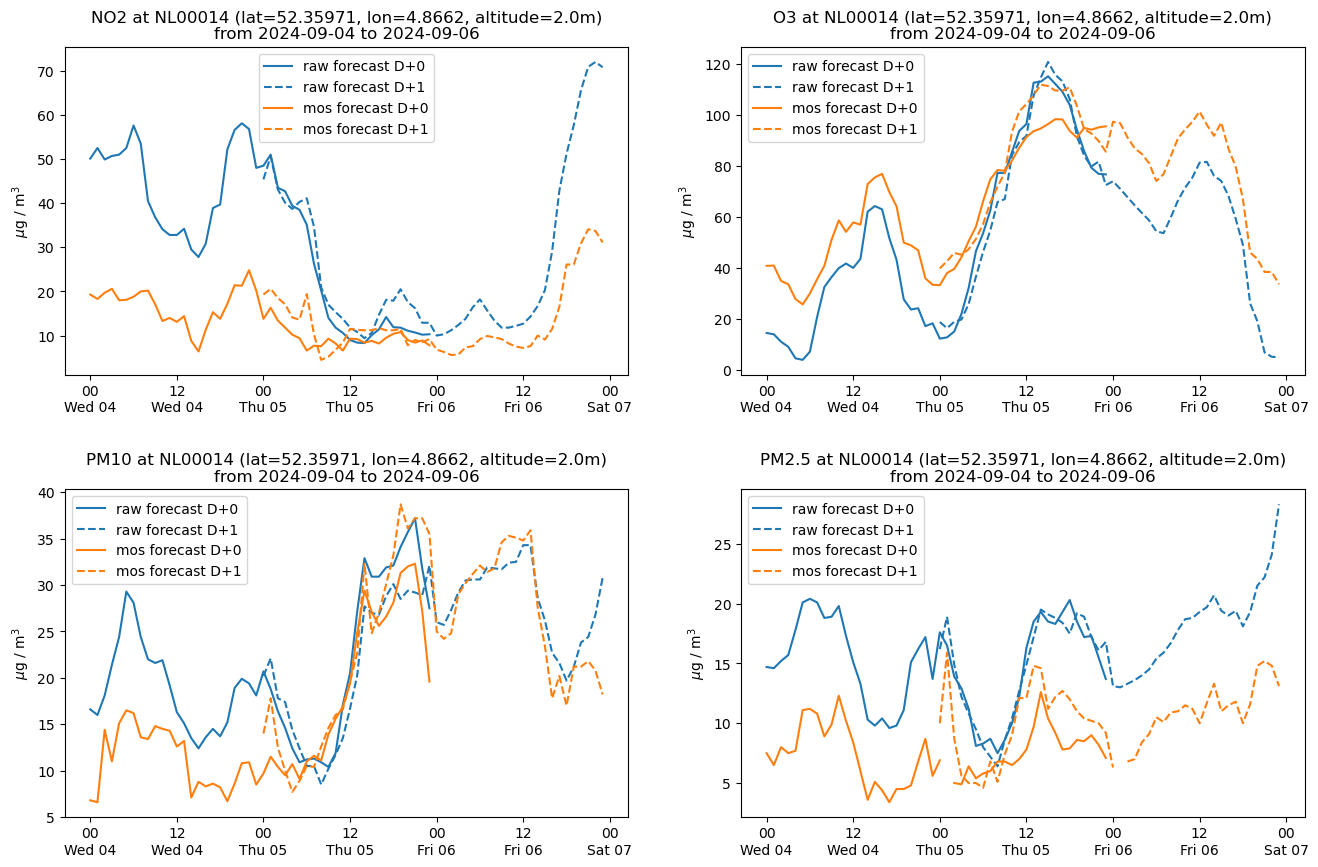

In [32]:
for station in merged_data.station_id.unique():
  
    # Extract station metadata for just this site. If there's more than one
    # entry we take the latest one that's valid within this time period
    sdata = station_data.loc[
            (station_data.id == station) &
            (station_data.date_start <= merged_data.datetime.iloc[-1]) &
            (station_data.date_end >= merged_data.datetime.iloc[0])
    ]
    assert len(sdata), 'No metadata for site?'
    sdata = sdata.iloc[-1, :]
  
    # Extract air quality data for just this site
    adata = merged_data[merged_data.station_id == station]
  
    if len(adata) > 0:
        station_plot(sdata, adata, style)
        #print('Data available for ' + station)
    else:
            print('No data for ' + station)

## Average bias
The raw data is also said "biased" and the MOS data is said "unbiased" or bias-corrected. We calculate the mean bias for $NO_2$ at one station by calculating the root mean squared error RMSE

$$RMSE = \sqrt {\frac{1}{N} \sum_{h=1}^{N}(MOS_h - RAW_h)^2 }$$

where N is the number of hourly forecasts of a species.

In [33]:
station_pm10 = merged_data[ (merged_data['species'] == 'PM10')  &   
              (merged_data['station_id'] == 'NL00014') ] \
              .drop(['station_id', 'lead_time_hour', 'species'], axis=1).sort_values(by=['datetime'])
station_pm10.head(3)

,datetime,conc_mos_micrograms_per_m3,conc_raw_micrograms_per_m3
2,2024-09-04 00:00:00,6.8,16.6
6,2024-09-04 01:00:00,6.6,16.0
10,2024-09-04 02:00:00,14.4,18.1


In [34]:
pm10_conc_mos_micrograms_per_m3 = station_pm10.conc_mos_micrograms_per_m3
pm10_conc_raw_micrograms_per_m3 = station_pm10.conc_raw_micrograms_per_m3
pm10_bias = pm10_conc_mos_micrograms_per_m3 - pm10_conc_raw_micrograms_per_m3
squared_pm10_bias = pm10_bias ** 2
rmse = math.sqrt(squared_pm10_bias.mean())
print('Average PM10 Raw-MOS-optimised bias: {:.2f} micrograms/m3'.format(rmse))

Average PM10 Raw-MOS-optimised bias: 5.59 micrograms/m3


In [35]:
date_index = pd.to_datetime(station_pm10['datetime'])
station_pm10_time_index = station_pm10.set_index(date_index).drop(['datetime'], axis=1)
station_pm10_time_index.head(3)

,conc_mos_micrograms_per_m3,conc_raw_micrograms_per_m3
datetime,,
2024-09-04 00:00:00,6.8,16.6
2024-09-04 01:00:00,6.6,16.0
2024-09-04 02:00:00,14.4,18.1


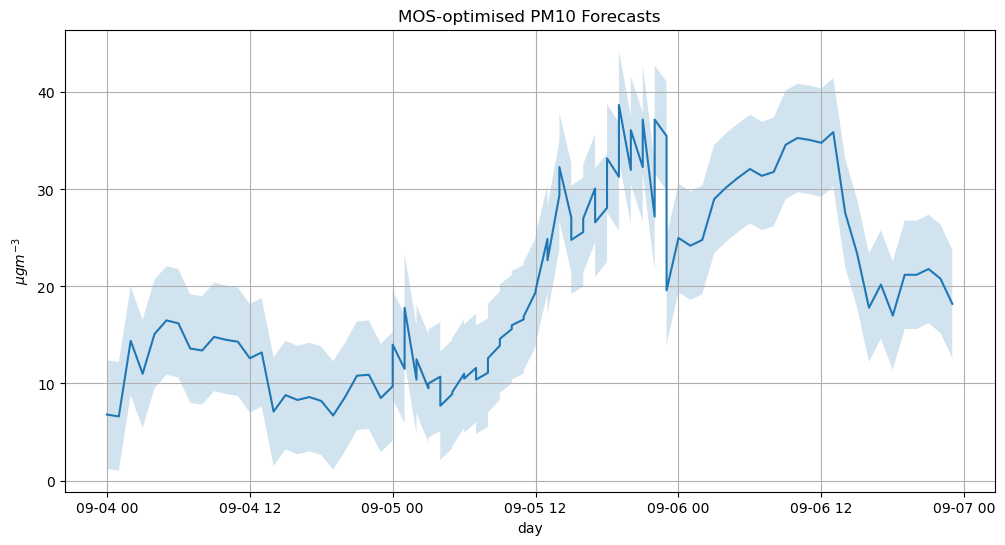

In [36]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.grid(True, which='both')
ax.set_title("MOS-optimised PM10 Forecasts")
ax.set_xlabel("day")
ax.set_ylabel("$\mu gm^{-3}$");
#ax.set_xticks(week_index)
#ax.set_xticklabels(week_index, rotation=70)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
pm_10_mos = station_pm10_time_index['conc_mos_micrograms_per_m3']
pm10_raw = station_pm10_time_index['conc_raw_micrograms_per_m3']
plt_giss_error = ax.fill_between(pm_10_mos.index, pm_10_mos - rmse, pm_10_mos + rmse, alpha=0.2)
plt.plot(pm_10_mos)

## Number of daily max concentration
We calculate the number of daily maximum concentration of PM10 above 130 $\mu gm^{-3}$ for the MOS and and the raw ensemble forecasts. 

In [37]:
pm10_max_concentration_threshold = 26.5

In [38]:
station_pm10_mos_max = station_pm10.conc_mos_micrograms_per_m3.max()
station_pm10_mos_max

np.float64(38.7)

In [39]:
station_pm10_raw_max = station_pm10.conc_raw_micrograms_per_m3.max()
station_pm10_raw_max

np.float64(37.2)

In [40]:
station_pm10_max_daily = station_pm10_time_index.groupby(pd.Grouper(freq='D')).max()
station_pm10_max_daily

,conc_mos_micrograms_per_m3,conc_raw_micrograms_per_m3
datetime,,
2024-09-04,16.5,29.3
2024-09-05,38.7,37.2
2024-09-06,35.9,34.3


In [41]:
station_pm10_mos_max_daily = station_pm10_max_daily[station_pm10_max_daily['conc_mos_micrograms_per_m3'] > 
                             pm10_max_concentration_threshold].drop(['conc_raw_micrograms_per_m3'], axis=1)
station_pm10_mos_max_daily

,conc_mos_micrograms_per_m3
datetime,
2024-09-05,38.7
2024-09-06,35.9


In [42]:
station_pm10_raw_max_daily = station_pm10_max_daily[station_pm10_max_daily['conc_raw_micrograms_per_m3'] > 
                             pm10_max_concentration_threshold].drop(['conc_mos_micrograms_per_m3'], axis=1)
station_pm10_raw_max_daily

,conc_raw_micrograms_per_m3
datetime,
2024-09-04,29.3
2024-09-05,37.2
2024-09-06,34.3


## References
* [Bertrand, Meleux, Ung, Descombes, Colette - Technical note: Improving the European air quality forecast of the Copernicus Atmosphere Monitoring Service using machine learning techniques](https://acp.copernicus.org/articles/23/5317/2023/)